In [1]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**adenomas** and **non-neoplastics**. We have about 125 training images each for adenomas and non-neoplastic.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/pituitary_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

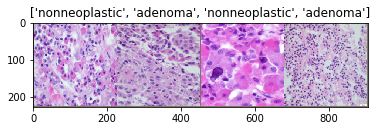

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.5196 Acc: 0.7800


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2859 Acc: 0.9067

Epoch 1/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3020 Acc: 0.8600


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.7350 Acc: 0.8333

Epoch 2/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.5020 Acc: 0.8280


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.5280 Acc: 0.9200

Epoch 3/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.4300 Acc: 0.8840


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

val Loss: 0.7279 Acc: 0.9267

Epoch 4/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.4439 Acc: 0.8680


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.5562 Acc: 0.9267

Epoch 5/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3666 Acc: 0.8840


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3438 Acc: 0.9333

Epoch 6/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2758 Acc: 0.9000


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.8832 Acc: 0.8667

Epoch 7/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.4658 Acc: 0.8880


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.8318 Acc: 0.9200

Epoch 8/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2845 Acc: 0.9320


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.7026 Acc: 0.9200

Epoch 9/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

train Loss: 0.3223 Acc: 0.9000


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3960 Acc: 0.9200

Epoch 10/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.2605 Acc: 0.9120


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

val Loss: 0.3559 Acc: 0.9200

Epoch 11/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2222 Acc: 0.9320


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2620 Acc: 0.9133

Epoch 12/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2732 Acc: 0.8960


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2619 Acc: 0.9200

Epoch 13/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1265 Acc: 0.9440


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.2253 Acc: 0.9133

Epoch 14/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1561 Acc: 0.9280


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2312 Acc: 0.9200

Epoch 15/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

train Loss: 0.1414 Acc: 0.9480


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3090 Acc: 0.9133

Epoch 16/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.1773 Acc: 0.9400


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3532 Acc: 0.9267

Epoch 17/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

train Loss: 0.1304 Acc: 0.9560


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.4295 Acc: 0.9133

Epoch 18/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1907 Acc: 0.9240


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2930 Acc: 0.9133

Epoch 19/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.1656 Acc: 0.9400


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3647 Acc: 0.9133

Epoch 20/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1121 Acc: 0.9560


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.2934 Acc: 0.9200

Epoch 21/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1867 Acc: 0.9080


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3212 Acc: 0.9133

Epoch 22/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1575 Acc: 0.9440


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3474 Acc: 0.9133

Epoch 23/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1502 Acc: 0.9280


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2593 Acc: 0.9133

Epoch 24/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.1533 Acc: 0.9480


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.2851 Acc: 0.9267

Training complete in 11m 32s
Best val Acc: 0.933333


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

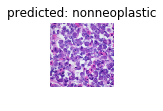

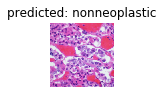

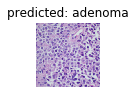

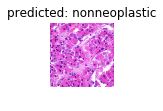

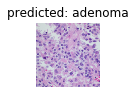

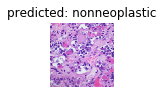

In [17]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.6119 Acc: 0.7000


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3008 Acc: 0.8600

Epoch 1/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3771 Acc: 0.8360


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2659 Acc: 0.8800

Epoch 2/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

train Loss: 0.3624 Acc: 0.8480


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2718 Acc: 0.8800

Epoch 3/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.4734 Acc: 0.7840


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2625 Acc: 0.8933

Epoch 4/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3667 Acc: 0.8440


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.2378 Acc: 0.9200

Epoch 5/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.4919 Acc: 0.7920


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2895 Acc: 0.8733

Epoch 6/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.4017 Acc: 0.8360


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3329 Acc: 0.8867

Epoch 7/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3651 Acc: 0.8640


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3021 Acc: 0.8667

Epoch 8/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.3133 Acc: 0.8920


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3277 Acc: 0.8733

Epoch 9/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.2255 Acc: 0.9080


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3965 Acc: 0.8667

Epoch 10/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3969 Acc: 0.8320


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3011 Acc: 0.9000

Epoch 11/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.2950 Acc: 0.8640


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3314 Acc: 0.9000

Epoch 12/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3684 Acc: 0.8200


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

val Loss: 0.2837 Acc: 0.9067

Epoch 13/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

train Loss: 0.3169 Acc: 0.8640


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.2861 Acc: 0.8933

Epoch 14/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2436 Acc: 0.8880


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3109 Acc: 0.8733

Epoch 15/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3343 Acc: 0.8680


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

val Loss: 0.2873 Acc: 0.8867

Epoch 16/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2969 Acc: 0.8760


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3102 Acc: 0.8867

Epoch 17/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3883 Acc: 0.8320


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3074 Acc: 0.8867

Epoch 18/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2802 Acc: 0.9000


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3337 Acc: 0.9000

Epoch 19/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

train Loss: 0.3153 Acc: 0.8680


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3352 Acc: 0.9067

Epoch 20/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.3713 Acc: 0.8480


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.4059 Acc: 0.8667

Epoch 21/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2603 Acc: 0.8840


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

val Loss: 0.3362 Acc: 0.8933

Epoch 22/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.1981 Acc: 0.9240


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

val Loss: 0.3118 Acc: 0.9000

Epoch 23/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

train Loss: 0.2580 Acc: 0.8880


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3142 Acc: 0.8733

Epoch 24/24
----------


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.

train Loss: 0.2494 Acc: 0.8840


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImageP

val Loss: 0.3192 Acc: 0.9000

Training complete in 4m 39s
Best val Acc: 0.920000


/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlug

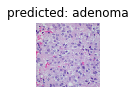

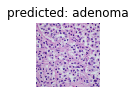

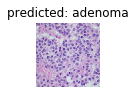

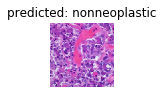

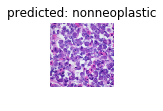

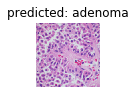

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()